In [1]:
# Importing necessary libraries and modules
import warnings  # Import the 'warnings' module for handling warnings
warnings.filterwarnings("ignore")  # Ignore warnings during execution

import gc  # Import the 'gc' module for garbage collection
import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import Pandas for data manipulation
import itertools  # Import 'itertools' for iterators and looping
from collections import Counter  # Import 'Counter' for counting elements
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)

# Import custom modules and classes
from imblearn.over_sampling import RandomOverSampler # import RandomOverSampler
import accelerate # Import the 'accelerate' module
import evaluate  # Import the 'evaluate' module
from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel', and 'Image' classes
from transformers import (  # Import various modules from the Transformers library
    TrainingArguments,  # For training arguments
    Trainer,  # For model training
    ViTImageProcessor,  # For processing image data with ViT models
    ViTForImageClassification,  # ViT model for image classification
    DefaultDataCollator  # For collating data in the default way
)
import torch  # Import PyTorch for deep learning
from torch.utils.data import DataLoader  # For creating data loaders
from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)

In [2]:
# Import the necessary module from the Python Imaging Library (PIL).
from PIL import ImageFile

# Enable the option to load truncated images.
# This setting allows the PIL library to attempt loading images even if they are corrupted or incomplete.
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
# use https://huggingface.co/docs/datasets/image_load for reference

# Import necessary libraries
image_dict = {}

from pathlib import Path
from tqdm import tqdm

labels = []
file_names = []

# Iterate through all image files in the specified directory
for file in tqdm(sorted((Path(r'C:\Users\sivab\Downloads\archive (15)\crop').glob('*\*.*g')))):
    parts = str(file).split('\\')  # Use backslash for Windows paths
    if len(parts) >= 2:  # Safety check
        label = parts[-2]  # Extract the label from the file path
        labels.append(label)
        file_names.append(str(file))
# Print the total number of file names and labels
print(len(file_names), len(labels))

# Create a pandas dataframe from the collected file names and labels
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})
print(df.shape)

100%|██████████| 20541/20541 [00:00<00:00, 229388.13it/s]

20541 20541
(20541, 2)


In [4]:
df.head()

,image,label
0,C:\Users\sivab\Downloads\archive (15)\crop\A10...,A10
1,C:\Users\sivab\Downloads\archive (15)\crop\A10...,A10
2,C:\Users\sivab\Downloads\archive (15)\crop\A10...,A10
3,C:\Users\sivab\Downloads\archive (15)\crop\A10...,A10
4,C:\Users\sivab\Downloads\archive (15)\crop\A10...,A10


In [5]:
df['label'].unique()

array(['A10', 'A400M', 'An22', 'An225', 'An72', 'B1', 'B2', 'B21', 'B52',
       'C130', 'C17', 'C2', 'C390', 'C5', 'E2', 'E7', 'F117', 'F14',
       'F15', 'F16', 'F18', 'F22', 'F35', 'F4', 'H6', 'J10', 'J20', 'J35',
       'JH7', 'Ka27', 'Ka52', 'KAAN', 'KJ600', 'Mi24', 'Mi26', 'Mi28',
       'Mig29', 'Mig31', 'Mirage2000', 'Rafale'], dtype=object)

In [6]:
# random oversampling of minority class
# 'y' contains the target variable (label) we want to predict
y = df[['label']]

# Drop the 'label' column from the DataFrame 'df' to separate features from the target variable
df = df.drop(['label'], axis=1)

# Create a RandomOverSampler object with a specified random seed (random_state=83)
ros = RandomOverSampler(random_state=83)

# Use the RandomOverSampler to resample the dataset by oversampling the minority class
# 'df' contains the feature data, and 'y_resampled' will contain the resampled target variable
df, y_resampled = ros.fit_resample(df, y)

# Delete the original 'y' variable to save memory as it's no longer needed
del y

# Add the resampled target variable 'y_resampled' as a new 'label' column in the DataFrame 'df'
df['label'] = y_resampled

# Delete the 'y_resampled' variable to save memory as it's no longer needed
del y_resampled

# Perform garbage collection to free up memory used by discarded variables
gc.collect()

print(df.shape)

(72080, 2)


In [7]:
dataset = Dataset.from_pandas(df).cast_column("image", Image())

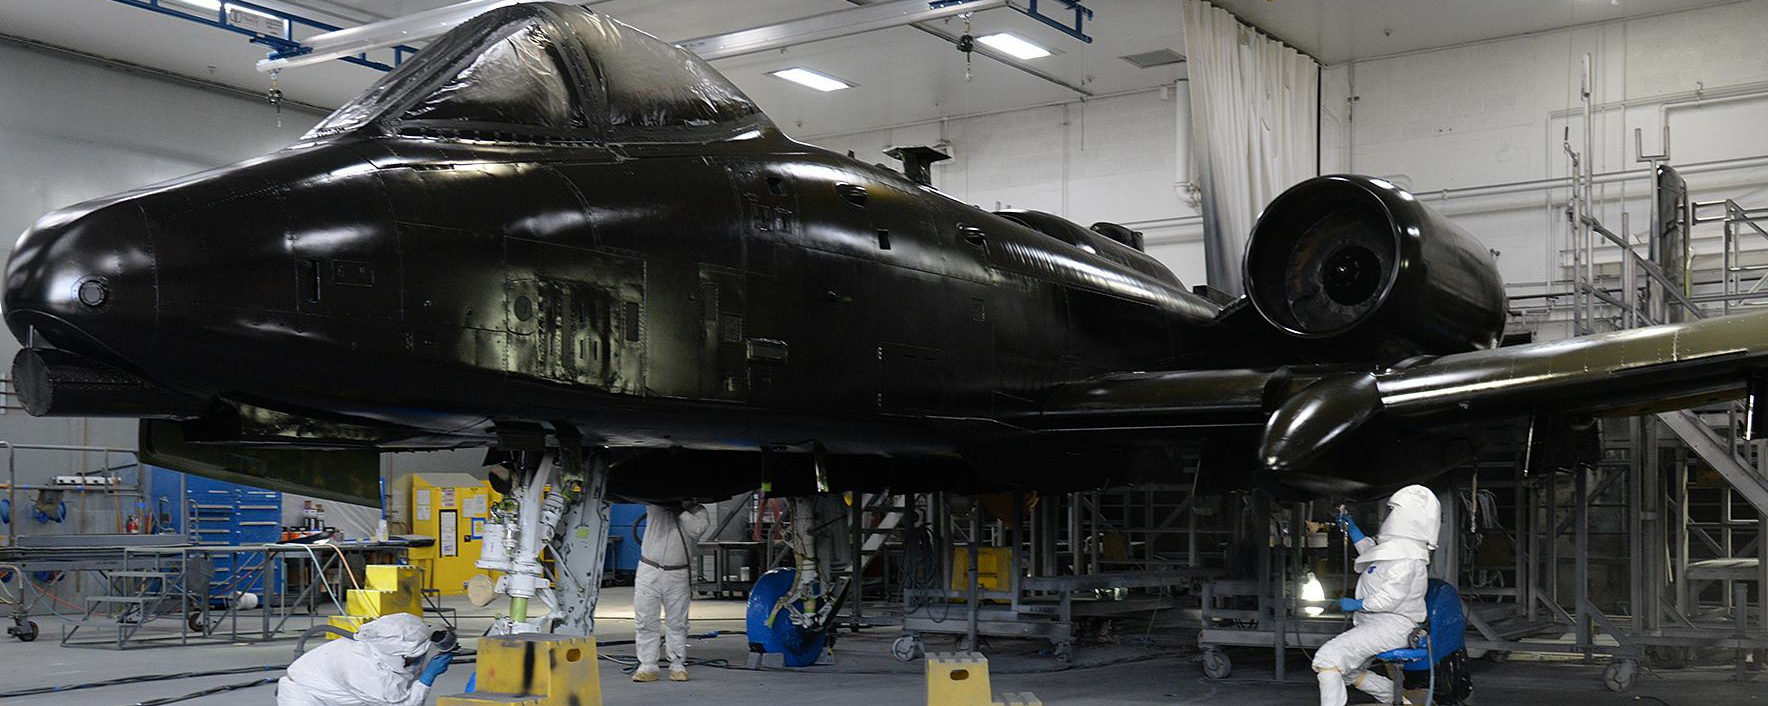

In [8]:
dataset[0]["image"]

In [9]:
# Extracting a subset of elements from the 'labels' list using slicing.
# The slicing syntax [:5] selects elements from the beginning up to (but not including) the 5th element.
# This will give us the first 5 elements of the 'labels' list.
# The result will be a new list containing these elements.
labels_subset = labels[:5]

# Printing the subset of labels to inspect the content.
print(labels_subset)

['A10', 'A10', 'A10', 'A10', 'A10']


In [10]:
# Create a list of unique labels by converting 'labels' to a set and then back to a list
labels_list = sorted(list(set(labels)))

# Initialize empty dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()

# Iterate over the unique labels and assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'A10', 1: 'A400M', 2: 'An22', 3: 'An225', 4: 'An72', 5: 'B1', 6: 'B2', 7: 'B21', 8: 'B52', 9: 'C130', 10: 'C17', 11: 'C2', 12: 'C390', 13: 'C5', 14: 'E2', 15: 'E7', 16: 'F117', 17: 'F14', 18: 'F15', 19: 'F16', 20: 'F18', 21: 'F22', 22: 'F35', 23: 'F4', 24: 'H6', 25: 'J10', 26: 'J20', 27: 'J35', 28: 'JH7', 29: 'KAAN', 30: 'KJ600', 31: 'Ka27', 32: 'Ka52', 33: 'Mi24', 34: 'Mi26', 35: 'Mi28', 36: 'Mig29', 37: 'Mig31', 38: 'Mirage2000', 39: 'Rafale'} 

Mapping of Labels to IDs: {'A10': 0, 'A400M': 1, 'An22': 2, 'An225': 3, 'An72': 4, 'B1': 5, 'B2': 6, 'B21': 7, 'B52': 8, 'C130': 9, 'C17': 10, 'C2': 11, 'C390': 12, 'C5': 13, 'E2': 14, 'E7': 15, 'F117': 16, 'F14': 17, 'F15': 18, 'F16': 19, 'F18': 20, 'F22': 21, 'F35': 22, 'F4': 23, 'H6': 24, 'J10': 25, 'J20': 26, 'J35': 27, 'JH7': 28, 'KAAN': 29, 'KJ600': 30, 'Ka27': 31, 'Ka52': 32, 'Mi24': 33, 'Mi26': 34, 'Mi28': 35, 'Mig29': 36, 'Mig31': 37, 'Mirage2000': 38, 'Rafale': 39}


In [11]:
# Creating classlabels to match labels to IDs
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

# Casting label column to ClassLabel Object
dataset = dataset.cast_column('label', ClassLabels)

# Splitting the dataset into training and testing sets
dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")

# Extracting the training data from the split dataset.
train_data = dataset['train']

# Extracting the testing data from the split dataset.
test_data = dataset['test']

Casting the dataset: 100%|██████████| 72080/72080 [00:00<00:00, 2580647.47 examples/s]


In [12]:
import torch
from torchvision.transforms import Compose, Resize, RandomRotation, RandomAdjustSharpness, RandomHorizontalFlip, ToTensor, Normalize
from transformers import ViTImageProcessor, ViTForImageClassification

# Check for GPU and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the pre-trained model string
model_str = "dima806/military_aircraft_image_detection"

# Create a processor for ViT model input from the pre-trained model
processor = ViTImageProcessor.from_pretrained(model_str)

# Retrieve image normalization stats
image_mean, image_std = processor.image_mean, processor.image_std

# Get input image size
size = processor.size["height"]
print("Input size: ", size)

# Define normalization
normalize = Normalize(mean=image_mean, std=image_std)

# Define training transforms
_train_transforms = Compose([
    Resize((size, size)),
    RandomRotation(90),
    RandomAdjustSharpness(2),
    RandomHorizontalFlip(0.5),
    ToTensor(),
    normalize
])

# Define validation transforms
_val_transforms = Compose([
    Resize((size, size)),
    ToTensor(),
    normalize
])

# Transform functions for datasets
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Apply transforms to datasets
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

# Collate function for DataLoader
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])  # CPU tensors
    labels = torch.tensor([example["label"] for example in examples])              # CPU tensor
    return {
        "pixel_values": pixel_values,
        "labels": labels
    }


# Load base ViT model and fine-tune for specific task
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=len(labels_list))
model.to(device)  # Move model to GPU

# Configure label maps
model.config.id2label = id2label
model.config.label2id = label2id

# Print number of trainable parameters
print(f"Trainable parameters: {model.num_parameters(only_trainable=True) / 1e6:.2f}M")


Using device: cuda
Input size:  224


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: 85.83M


In [13]:
# Load the accuracy metric
accuracy_metric = evaluate.load("accuracy")

# Define metric computation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Convert logits to predicted class indices
    preds = np.argmax(logits, axis=1)

    # Compute accuracy
    acc = accuracy_metric.compute(predictions=preds, references=labels)

    return {"accuracy": acc["accuracy"]}

In [15]:
from transformers import TrainingArguments
import torch

# Define metric and model names
metric_name = "accuracy"
model_name = "military_aircraft_image_detection"
num_train_epochs = 10  # Set to 1 for quick tests, bump to 10+ for full training

# Set optimized training arguments
args = TrainingArguments(
    output_dir=model_name,                    # Save model checkpoints and outputs here
    logging_dir='./logs',                     # Directory for training logs

    eval_strategy="epoch",              # Evaluate at the end of each epoch
    save_strategy="epoch",                    # Save checkpoint each epoch

    learning_rate=1e-5,                       # Slightly higher LR for quicker convergence
    per_device_train_batch_size=16,           # Reduce if OOM, increase if you’ve got VRAM
    per_device_eval_batch_size=32,

    num_train_epochs=num_train_epochs,
    weight_decay=0.01,                        # Moderate weight decay
    warmup_steps=0,                           # No warmup = faster startup

    remove_unused_columns=False,              # Needed when using custom transforms

    load_best_model_at_end=True,              # Automatically keep the best checkpoint
    metric_for_best_model=metric_name,        # Use accuracy to choose best model
    greater_is_better=True,                   # Higher accuracy = better

    save_total_limit=1,                       # Only keep the latest best model to save space

    report_to="none",                         # Disable default logging
    logging_strategy="epoch",                 # Log once per epoch
    disable_tqdm=False,                       # Enable progress bar

    fp16=torch.cuda.is_available(),           # Use half-precision if GPU is available
)


In [16]:
# Create a Trainer instance for fine-tuning a language model.

# - `model`: The pre-trained language model to be fine-tuned.
# - `args`: Configuration settings and hyperparameters for training.
# - `train_dataset`: The dataset used for training the model.
# - `eval_dataset`: The dataset used for evaluating the model during training.
# - `data_collator`: A function that defines how data batches are collated and processed.
# - `compute_metrics`: A function for computing custom evaluation metrics.
# - `tokenizer`: The tokenizer used for processing text data.

trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [17]:
print(train_data.column_names)

['image', 'label']


In [18]:
correct_image_key = "image"  # replace with the actual key you found from step 1

def train_transforms(examples):
    examples["pixel_values"] = [_train_transforms(image.convert("RGB")) for image in examples[correct_image_key]]
    return examples


In [19]:
sample = train_data[0]
print(sample)


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=79x53 at 0x25B9D692E00>, 'label': 9, 'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -

In [20]:
# Evaluate the pre-training model's performance on a test dataset.
# This function calculates various metrics such as accuracy, loss, etc.,
# to assess how well the model is performing on unseen data.

trainer.evaluate()

{'eval_loss': 3.6976113319396973,
 'eval_model_preparation_time': 0.0065,
 'eval_accuracy': 0.016301331853496116,
 'eval_runtime': 557.173,
 'eval_samples_per_second': 51.747,
 'eval_steps_per_second': 1.617}

In [21]:
trainer.train()



Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,2.787400,2.178824,0.006500,0.634711
2,1.521900,1.314545,0.006500,0.778371
3,0.829900,0.809593,0.006500,0.846525
4,0.461300,0.531058,0.006500,0.886238
5,0.277400,0.393260,0.006500,0.904134
6,0.178300,0.304402,0.006500,0.922725
7,0.122300,0.261746,0.006500,0.928170
8,0.091900,0.240515,0.006500,0.935731
9,0.070700,0.219479,0.006500,0.938506
10,0.058900,0.212692,0.006500,0.941905


TrainOutput(global_step=27030, training_loss=0.6400103598314879, metrics={'train_runtime': 19317.5434, 'train_samples_per_second': 22.388, 'train_steps_per_second': 1.399, 'total_flos': 3.3525149842986762e+19, 'train_loss': 0.6400103598314879, 'epoch': 10.0})

In [22]:
trainer.evaluate()


{'eval_loss': 0.21269217133522034,
 'eval_model_preparation_time': 0.0065,
 'eval_accuracy': 0.9419048279689234,
 'eval_runtime': 582.2267,
 'eval_samples_per_second': 49.52,
 'eval_steps_per_second': 1.548,
 'epoch': 10.0}

In [23]:
# Use the trained 'trainer' to make predictions on the 'test_data'.
outputs = trainer.predict(test_data)

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

{'test_loss': 0.21269217133522034, 'test_model_preparation_time': 0.0065, 'test_accuracy': 0.9419048279689234, 'test_runtime': 594.2151, 'test_samples_per_second': 48.521, 'test_steps_per_second': 1.516}


Accuracy: 0.9419
F1 Score: 0.9418


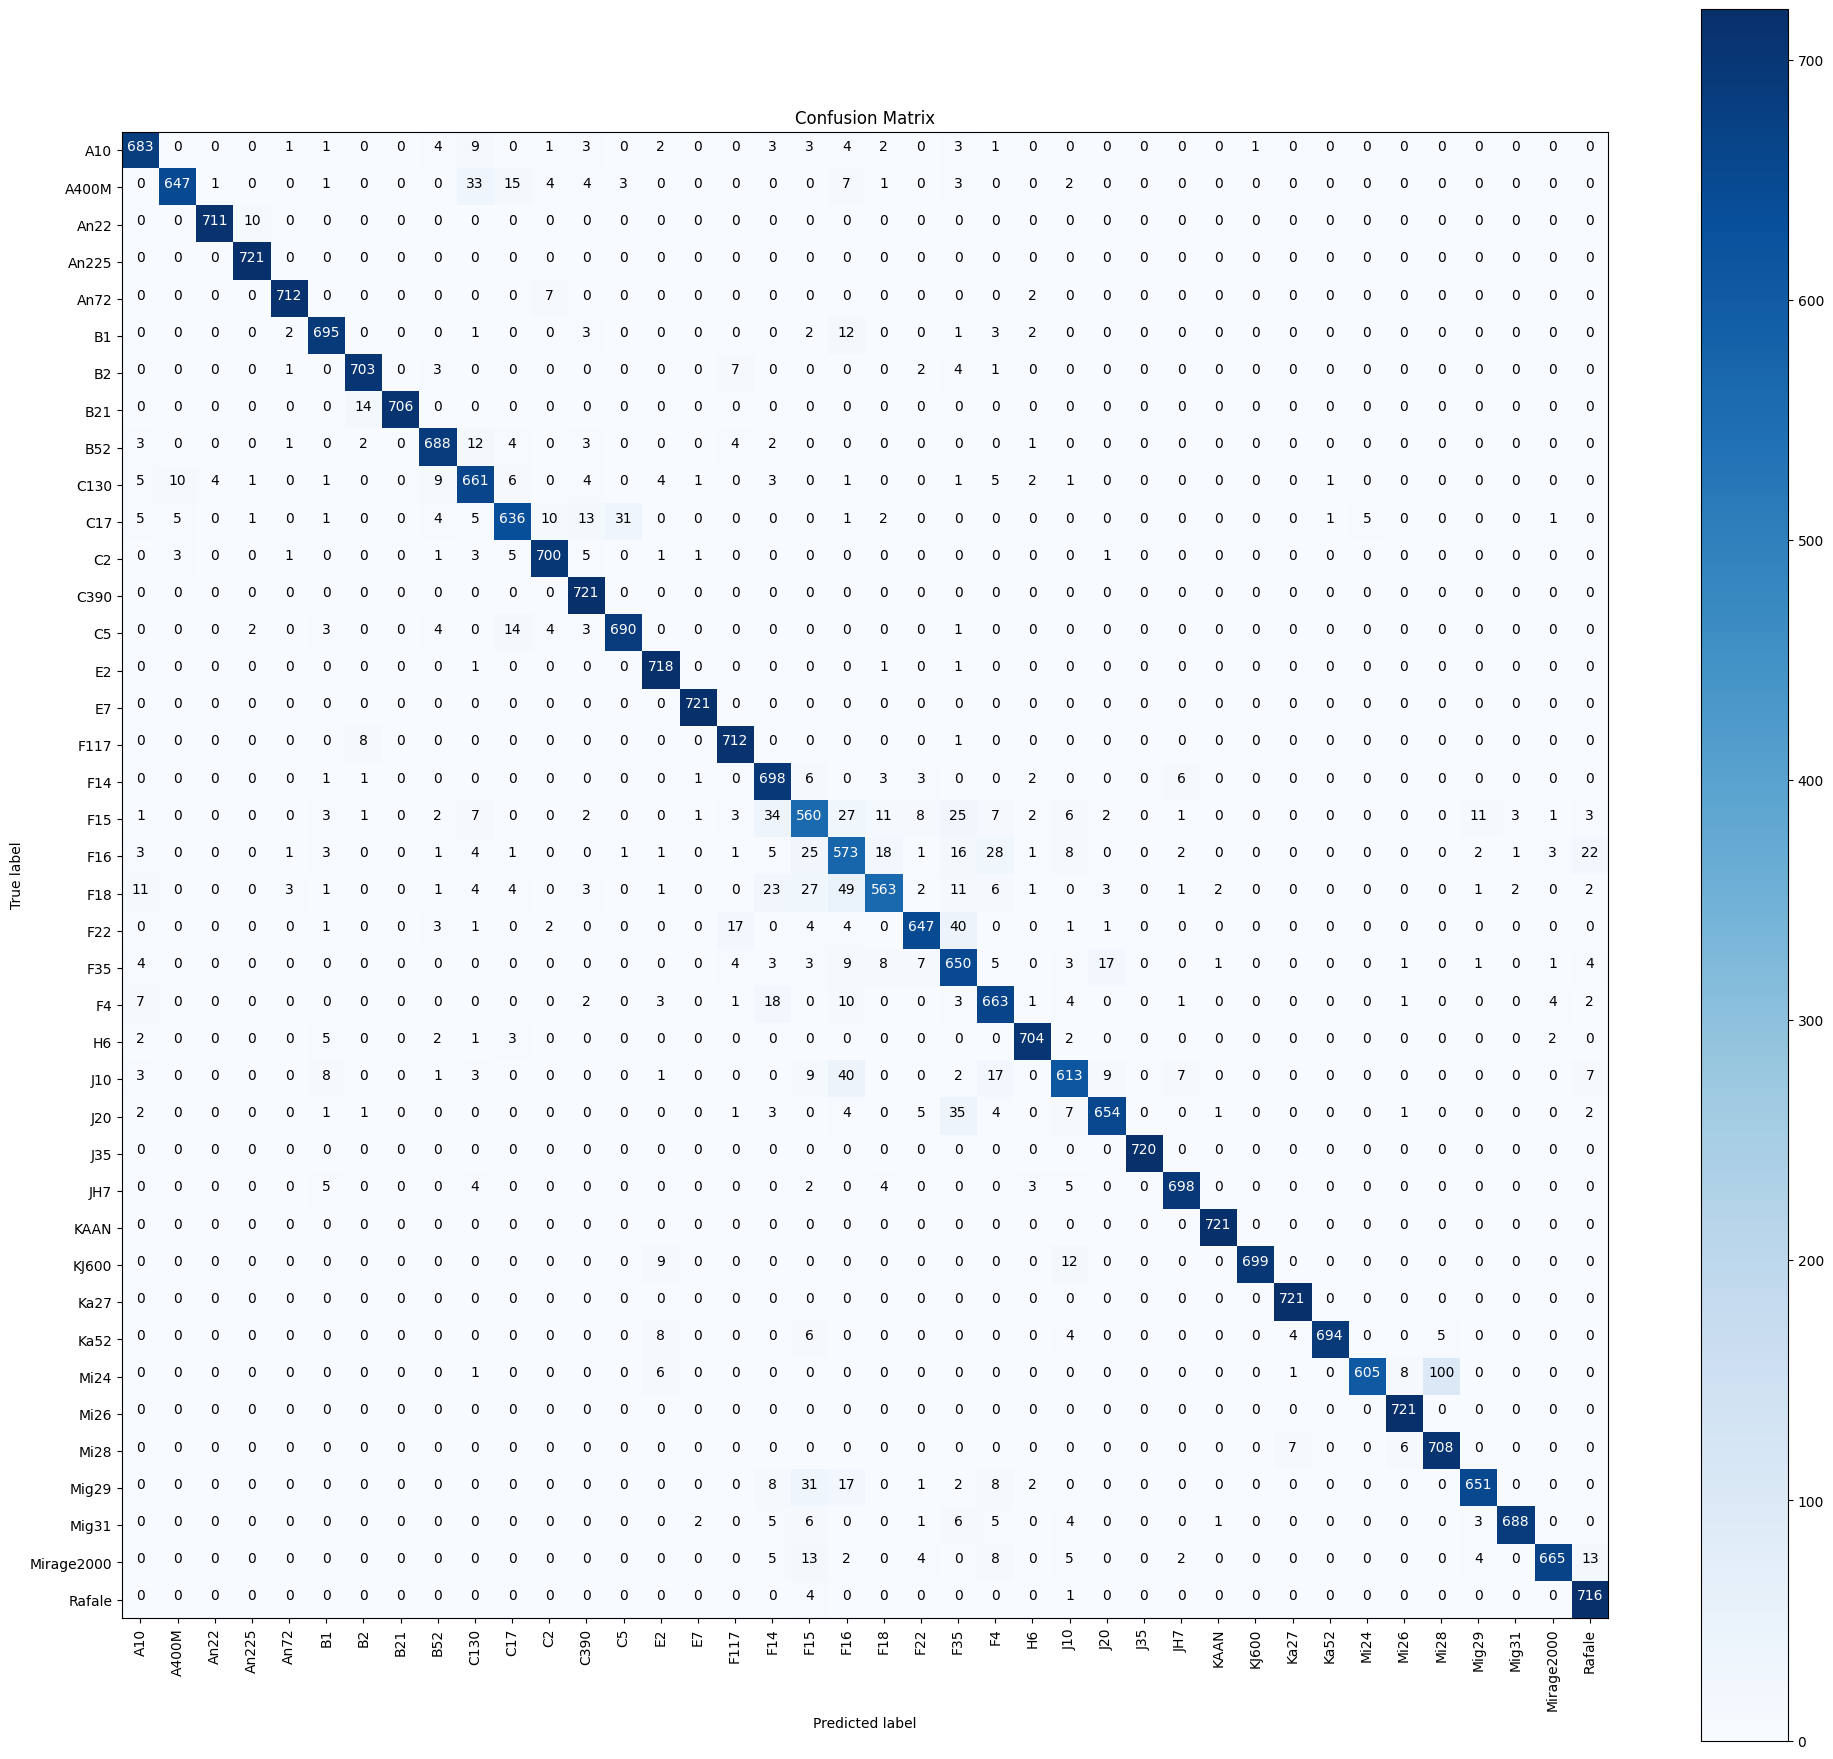


Classification report:

              precision    recall  f1-score   support

         A10     0.9369    0.9473    0.9421       721
       A400M     0.9729    0.8974    0.9336       721
        An22     0.9930    0.9861    0.9896       721
       An225     0.9810    1.0000    0.9904       721
        An72     0.9861    0.9875    0.9868       721
          B1     0.9521    0.9639    0.9580       721
          B2     0.9630    0.9750    0.9690       721
         B21     1.0000    0.9806    0.9902       720
         B52     0.9516    0.9556    0.9536       720
        C130     0.8813    0.9181    0.8993       720
         C17     0.9244    0.8821    0.9028       721
          C2     0.9615    0.9709    0.9662       721
        C390     0.9413    1.0000    0.9697       721
          C5     0.9517    0.9570    0.9544       721
          E2     0.9523    0.9958    0.9736       721
          E7     0.9917    1.0000    0.9959       721
        F117     0.9493    0.9875    0.9680       721
  

In [24]:
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)
    
    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a small number of labels
if len(labels_list) <= 250:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(20, 18))
    
# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [45]:
# Save trained ViT model
trainer.save_model("saved_vit_model")
processor.save_pretrained("saved_vit_model")
print("✅ Model and processor saved!")


✅ Model and processor saved!


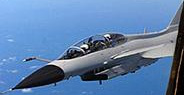

In [47]:
# Accessing an image from the 'test_data' dataset using index 1.
image = test_data[1]["image"]

# Displaying the 'image' variable.
image

In [48]:
id2label[test_data[1]["label"]]


'J10'